In [ ]:
#!pip3 install seaborn

#!pip3 uninstall tensorflow-gpu==1.8.0 -y
#!pip3 install tensorflow-gpu==1.8.0

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from glob import glob
import seaborn as sns

from PIL import Image
np.random.seed(123)

from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

import shutil
import itertools

from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

Using TensorFlow backend.


In [2]:
root_path = '/storage'
train_path = '/storage/ISIC_2019_Training_Input'

In [3]:
# Create a new directory
base_dir = 'base_dir'
# os.mkdir(base_dir)


## 9 Diagnostic Categories of Skin Cancer

# Melanoma -> MEL
# Melanocytic nevus -> NV
# Basal cell carcinoma -> BCC
# Actinic keratosis -> AK
# Benign keratosis (solar lentigo / seborrheic keratosis / lichen planus-like keratosis) -> BKL
# Dermatofibroma -> DF
# Vascular lesion -> VASC
# Squamous cell carcinoma -> SCC
# None of the others -> UNK


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 9 folders inside 'base_dir':

# train_dir
    # NV
    # MEL
    # BKL
    # BCC
    # AK
    # VASC
    # DF
    # SCC
    # UNK
 
# val_dir
    # NV
    # MEL
    # BKL
    # BCC
    # AK
    # VASC
    # DF
    # SCC
    # UNK

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
# os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
# os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# # create new folders inside train_dir
# nv = os.path.join(train_dir, 'NV')
# os.mkdir(nv)
# mel = os.path.join(train_dir, 'MEL')
# os.mkdir(mel)
# bkl = os.path.join(train_dir, 'BKL')
# os.mkdir(bkl)
# bcc = os.path.join(train_dir, 'BCC')
# os.mkdir(bcc)
# akiec = os.path.join(train_dir, 'AK')
# os.mkdir(akiec)
# vasc = os.path.join(train_dir, 'VASC')
# os.mkdir(vasc)
# df = os.path.join(train_dir, 'DF')
# os.mkdir(df)
# df = os.path.join(train_dir, 'SCC')
# os.mkdir(df)
# df = os.path.join(train_dir, 'UNK')
# os.mkdir(df)


# # create new folders inside val_dir
# nv = os.path.join(val_dir, 'NV')
# os.mkdir(nv)
# mel = os.path.join(val_dir, 'MEL')
# os.mkdir(mel)
# bkl = os.path.join(val_dir, 'BKL')
# os.mkdir(bkl)
# bcc = os.path.join(val_dir, 'BCC')
# os.mkdir(bcc)
# akiec = os.path.join(val_dir, 'AK')
# os.mkdir(akiec)
# vasc = os.path.join(val_dir, 'VASC')
# os.mkdir(vasc)
# df = os.path.join(val_dir, 'DF')
# os.mkdir(df)
# df = os.path.join(val_dir, 'SCC')
# os.mkdir(df)
# df = os.path.join(val_dir, 'UNK')
# os.mkdir(df)

In [4]:
metadata_path = '/storage/ISIC_2019_Training_Metadata.csv'
df_meta = pd.read_csv(metadata_path)
df_meta.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [5]:
gt_path = '/storage/ISIC_2019_Training_GroundTruth.csv'
df_gt = pd.read_csv(gt_path)
df_gt.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_cell_type = pd.DataFrame([x for x in np.where(df_gt == 1, df_gt.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))

In [7]:
df_cell_type.head()

,dx
0,NV
1,NV
2,MEL
3,NV
4,MEL


In [8]:
df = pd.concat([df_meta, df_cell_type], axis=1, join='inner')
df.head()

,image,age_approx,anatom_site_general,lesion_id,sex,dx
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


In [9]:
df.isnull().sum()

image                     0
age_approx              437
anatom_site_general    2631
lesion_id              2084
sex                     384
dx                        0
dtype: int64

In [10]:
df['age_approx'].fillna((df['age_approx'].mean()), inplace=True)

In [11]:
df.dropna(subset=['anatom_site_general', 'lesion_id', 'sex'], inplace=True)
df.isnull().sum()

image                  0
age_approx             0
anatom_site_general    0
lesion_id              0
sex                    0
dx                     0
dtype: int64

In [12]:
df['image'].head()

1459    ISIC_0012653_downsampled
1460    ISIC_0012654_downsampled
1461    ISIC_0012655_downsampled
1462    ISIC_0012656_downsampled
1463    ISIC_0012657_downsampled
Name: image, dtype: object

In [13]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(root_path, '*', '*.jpg'))}

lesion_type_dict = {
    'NV': 'Melanocytic nevi',
    'MEL': 'Melanoma',
    'BKL': 'Benign keratosis-like lesions ',
    'BCC': 'Basal cell carcinoma',
    'AK': 'Actinic keratoses',
    'VASC': 'Vascular lesions',
    'DF': 'Dermatofibroma',
    'SCC': 'Squamous cell carcinoma',
    'UNK': 'None of the others'
}

# Remove extraneous / redundant columns
# df.drop(['path', 'cell_type', 'cell_type_idx'], axis=1)

# Creating New Columns for better readability

df['path'] = df['image'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get) 
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,/storage/ISIC_2019_Training_Input/ISIC_0073247...,Basal cell carcinoma,1
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,/storage/ISIC_2019_Training_Input/ISIC_0073248...,Benign keratosis-like lesions,2
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,/storage/ISIC_2019_Training_Input/ISIC_0073249...,Melanoma,5
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,/storage/ISIC_2019_Training_Input/ISIC_0073251...,Melanocytic nevi,4
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,/storage/ISIC_2019_Training_Input/ISIC_0073254...,Benign keratosis-like lesions,2


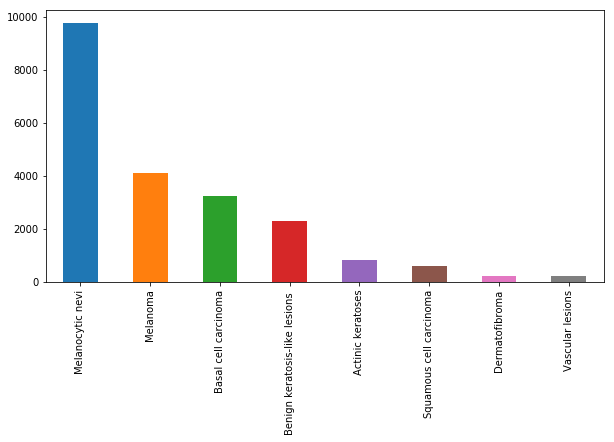

In [14]:
# Distribution of 9 classes
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

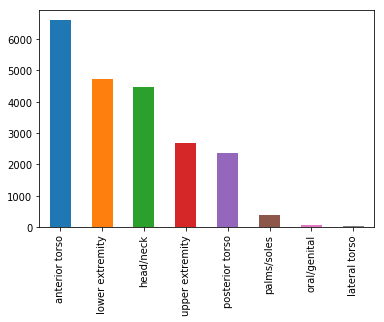

In [15]:
# Plotting the distribution of localization field
df['anatom_site_general'].value_counts().plot(kind='bar')

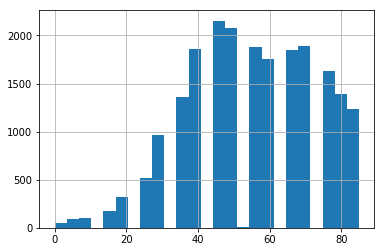

In [16]:
# Check the distribution of Age
df['age_approx'].hist(bins=25)

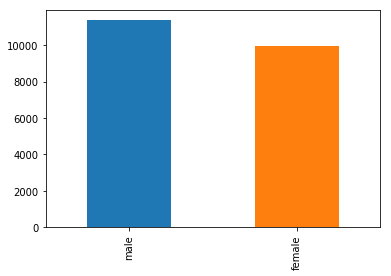

In [17]:
# Distribution of males and females
df['sex'].value_counts().plot(kind='bar')

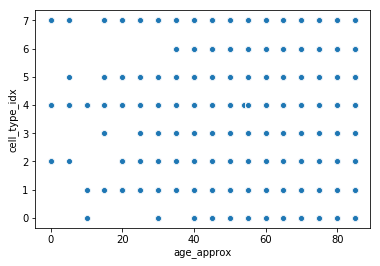

In [18]:
# Agewise distribution of skin cancer types
sns.scatterplot('age_approx','cell_type_idx', data=df)

In [19]:
# this will tell us how many images are associated with each lesion_id
df_ = df.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df_ = df_[df_['image'] == 1]

df_.reset_index(inplace=True)

df_.head()

,lesion_id,image,age_approx,anatom_site_general,sex,dx,path,cell_type,cell_type_idx
0,BCN_0000013,1,1,1,1,1,1,1,1
1,BCN_0000020,1,1,1,1,1,1,1,1
2,BCN_0000039,1,1,1,1,1,1,1,1
3,BCN_0000053,1,1,1,1,1,1,1,1
4,BCN_0000059,1,1,1,1,1,1,1,1


In [20]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df_['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df['duplicates'] = df['lesion_id']
# apply the function to this new column
df['duplicates'] = df['duplicates'].apply(identify_duplicates)

df.tail()

,image,age_approx,anatom_site_general,lesion_id,sex,dx,path,cell_type,cell_type_idx,duplicates
25326,ISIC_0073247,85.0,head/neck,BCN_0003925,female,BCC,/storage/ISIC_2019_Training_Input/ISIC_0073247...,Basal cell carcinoma,1,has_duplicates
25327,ISIC_0073248,65.0,anterior torso,BCN_0001819,male,BKL,/storage/ISIC_2019_Training_Input/ISIC_0073248...,Benign keratosis-like lesions,2,has_duplicates
25328,ISIC_0073249,70.0,lower extremity,BCN_0001085,male,MEL,/storage/ISIC_2019_Training_Input/ISIC_0073249...,Melanoma,5,has_duplicates
25329,ISIC_0073251,55.0,palms/soles,BCN_0002083,female,NV,/storage/ISIC_2019_Training_Input/ISIC_0073251...,Melanocytic nevi,4,has_duplicates
25330,ISIC_0073254,50.0,upper extremity,BCN_0001079,male,BKL,/storage/ISIC_2019_Training_Input/ISIC_0073254...,Benign keratosis-like lesions,2,has_duplicates


In [21]:
df['duplicates'].value_counts()

has_duplicates    15959
no_duplicates      5357
Name: duplicates, dtype: int64

In [22]:
# now we filter out images that don't have duplicates
df_ = df[df['duplicates'] == 'no_duplicates']

df_.shape

(5357, 10)

In [23]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df_['dx']

_, df_val = train_test_split(df_, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(911, 10)

In [24]:
df_val['dx'].value_counts()

NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [25]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df['train_or_val'] = df['image']
# apply the function to this new column
df['train_or_val'] = df['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df[df['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

20405
911


In [26]:
df_train['dx'].value_counts()

NV      9128
MEL     4027
BCC     3185
BKL     2188
AK       831
SCC      604
DF       228
VASC     214
Name: dx, dtype: int64

In [27]:
df_val['dx'].value_counts()

NV      623
BKL     107
MEL      74
BCC      60
SCC      18
AK       14
VASC      8
DF        7
Name: dx, dtype: int64

In [28]:
# Set the image as the index in df_data
df.set_index('image', inplace=True)

In [ ]:
# Get a list of images in the training folder
folder = os.listdir(train_path)

# Get a list of train and val images
train_list = list(df_train['image'])
val_list = list(df_val['image'])


# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        # source path to image
        src = os.path.join(train_path, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df.loc[image,'dx']
    
    if fname in folder:
        # source path to image
        src = os.path.join(train_path, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [29]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/NV')))
print(len(os.listdir('base_dir/train_dir/MEL')))
print(len(os.listdir('base_dir/train_dir/BKL')))
print(len(os.listdir('base_dir/train_dir/BCC')))
print(len(os.listdir('base_dir/train_dir/AK')))
print(len(os.listdir('base_dir/train_dir/VASC')))
print(len(os.listdir('base_dir/train_dir/DF')))
print(len(os.listdir('base_dir/train_dir/SCC')))
print(len(os.listdir('base_dir/train_dir/UNK')))

9128
9204
9202
9220
9060
7918
8436
8606
0


In [30]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/NV')))
print(len(os.listdir('base_dir/val_dir/MEL')))
print(len(os.listdir('base_dir/val_dir/BKL')))
print(len(os.listdir('base_dir/val_dir/BCC')))
print(len(os.listdir('base_dir/val_dir/AK')))
print(len(os.listdir('base_dir/val_dir/VASC')))
print(len(os.listdir('base_dir/val_dir/DF')))
print(len(os.listdir('base_dir/val_dir/SCC')))
print(len(os.listdir('base_dir/val_dir/UNK')))

623
74
107
60
14
8
7
18
0


In [ ]:
# Copy the train images into aug_dir
# note that we are not augmenting class 'nv'
class_list = ['MEL', 'BKL', 'BCC', 'AK', 'VASC', 'DF', 'SCC']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 9200 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 9200 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

In [31]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/NV')))
print(len(os.listdir('base_dir/train_dir/MEL')))
print(len(os.listdir('base_dir/train_dir/BKL')))
print(len(os.listdir('base_dir/train_dir/BCC')))
print(len(os.listdir('base_dir/train_dir/AK')))
print(len(os.listdir('base_dir/train_dir/VASC')))
print(len(os.listdir('base_dir/train_dir/DF')))
print(len(os.listdir('base_dir/train_dir/SCC')))
print(len(os.listdir('base_dir/train_dir/UNK')))

9128
9204
9202
9220
9060
7918
8436
8606
0


In [32]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/NV')))
print(len(os.listdir('base_dir/val_dir/MEL')))
print(len(os.listdir('base_dir/val_dir/BKL')))
print(len(os.listdir('base_dir/val_dir/BCC')))
print(len(os.listdir('base_dir/val_dir/AK')))
print(len(os.listdir('base_dir/val_dir/VASC')))
print(len(os.listdir('base_dir/val_dir/DF')))
print(len(os.listdir('base_dir/val_dir/SCC')))
print(len(os.listdir('base_dir/val_dir/UNK')))

623
74
107
60
14
8
7
18
0


In [ ]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

# def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
#     if type(ims[0]) is np.ndarray:
#         ims = np.array(ims).astype(np.uint8)
#         if (ims.shape[-1] != 3):
#             ims = ims.transpose((0,2,3,1))
#     f = plt.figure(figsize=figsize)
#     cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
#         if titles is not None:
#             sp.set_title(titles[i], fontsize=16)
#         plt.imshow(ims[i], interpolation=None if interp else 'none')
        
# plots(imgs, titles=None) # titles=labels will display the image labels

In [33]:
# Set Up the Generators
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)

train_batch_size = 20
val_batch_size = 20

# image_size = 224
image_size = 299

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [34]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    keras.applications.xception.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 70774 images belonging to 9 classes.
Found 911 images belonging to 9 classes.
Found 911 images belonging to 9 classes.


In [35]:
# create a copy of a mobilenet model
mobile = keras.applications.xception.Xception()

In [36]:
mobile.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [37]:
type(mobile.layers)

list

In [38]:
# How many layers does MobileNet have?
len(mobile.layers)

134

In [39]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-2].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(9, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [48]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 23 layers in the new model.
# The last 23 layers of the model will be trained.

for layer in model.layers[:-134]:
    layer.trainable = False

In [49]:
# Define Top2 and Top3 Accuracy

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [50]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])

In [51]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'UNK': 7, 'VASC': 8}


In [56]:
# Add weights to try to make the model more sensitive to melanoma

class_weights = {
    0: 1.0,  # AK
    1: 1.0,  # BCC
    2: 1.0,  # BKL
    3: 1.0,  # DF
    4: 3.0,  # MEL # Try to make the model more sensitive to Melanoma.
    5: 1.0,  # NV
    6: 1.0,  # SCC
    7: 1.0,  # UNK
    8: 1.0,  # VASC
}

In [46]:
filepath = "xception-134-trial03.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)

Epoch 1/30
1021/1021 [==============================] - 533s 522ms/step - loss: 2.5492 - categorical_accuracy: 0.1289 - top_2_accuracy: 0.2683 - top_3_accuracy: 0.4044 - val_loss: 2.2014 - val_categorical_accuracy: 0.0812 - val_top_2_accuracy: 0.1493 - val_top_3_accuracy: 0.2031

Epoch 00001: val_top_3_accuracy improved from -inf to 0.20307, saving model to xception-134-trial03.h5
Epoch 2/30
1021/1021 [==============================] - 526s 515ms/step - loss: 2.3023 - categorical_accuracy: 0.1846 - top_2_accuracy: 0.3718 - top_3_accuracy: 0.5244 - val_loss: 3.7863 - val_categorical_accuracy: 0.0801 - val_top_2_accuracy: 0.4248 - val_top_3_accuracy: 0.5499

Epoch 00002: val_top_3_accuracy improved from 0.20307 to 0.54995, saving model to xception-134-trial03.h5
Epoch 3/30
1021/1021 [==============================] - 529s 518ms/step - loss: 2.0542 - categorical_accuracy: 0.2861 - top_2_accuracy: 0.4994 - top_3_accuracy: 0.6514 - val_loss: 1.3067 - val_categorical_accuracy: 0.5291 - val_t


Epoch 00022: val_top_3_accuracy improved from 0.95499 to 0.95829, saving model to xception-134-trial03.h5
Epoch 23/30
1021/1021 [==============================] - 531s 520ms/step - loss: 0.7307 - categorical_accuracy: 0.7609 - top_2_accuracy: 0.9116 - top_3_accuracy: 0.9691 - val_loss: 0.6763 - val_categorical_accuracy: 0.7497 - val_top_2_accuracy: 0.8902 - val_top_3_accuracy: 0.9539

Epoch 00023: val_top_3_accuracy did not improve from 0.95829
Epoch 24/30
1021/1021 [==============================] - 529s 519ms/step - loss: 0.7125 - categorical_accuracy: 0.7628 - top_2_accuracy: 0.9158 - top_3_accuracy: 0.9702 - val_loss: 0.5987 - val_categorical_accuracy: 0.7859 - val_top_2_accuracy: 0.8957 - val_top_3_accuracy: 0.9583

Epoch 00024: val_top_3_accuracy did not improve from 0.95829

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0003124999930150807.
Epoch 25/30
1021/1021 [==============================] - 526s 515ms/step - loss: 0.6862 - categorical_accuracy: 0.7734 - top_2

In [47]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [48]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.631986490604363
val_cat_acc: 0.7782656421514819
val_top_2_acc: 0.897914379802415
val_top_3_acc: 0.9571899012074643


In [49]:
# Here the best epoch will be used.

model.load_weights('xception-134-trial03.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.602271371741457
val_cat_acc: 0.7848518111964874
val_top_2_acc: 0.9012074643249177
val_top_3_acc: 0.9582875960482986


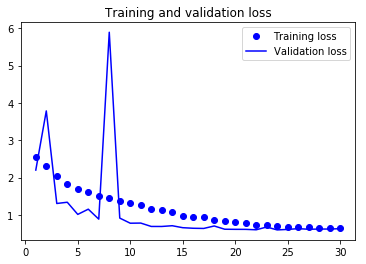

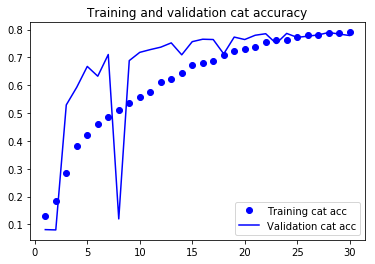

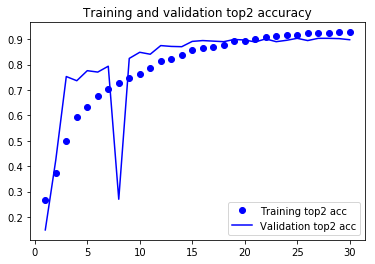

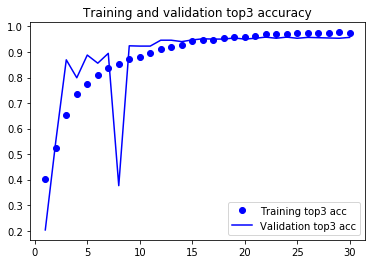

In [50]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()



plt.show()

In [51]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [52]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [53]:
# Print the label associated with each class
test_batches.class_indices

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'MEL': 4,
 'NV': 5,
 'SCC': 6,
 'UNK': 7,
 'VASC': 8}

In [54]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

911/911 [==============================] - 24s 26ms/step


In [55]:
predictions.shape

(911, 9)

In [56]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [57]:
test_labels.shape

(911,)

In [58]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [59]:
test_batches.class_indices

{'AK': 0,
 'BCC': 1,
 'BKL': 2,
 'DF': 3,
 'MEL': 4,
 'NV': 5,
 'SCC': 6,
 'UNK': 7,
 'VASC': 8}

Confusion matrix, without normalization
[[  6   2   2   0   4   0   0   0]
 [  1  39   3   0   9   7   0   1]
 [  2   7  36   2  31  27   2   0]
 [  0   1   0   4   0   2   0   0]
 [  2   0   4   0  52  16   0   0]
 [  0   5   9   2  38 568   0   1]
 [  1   2   1   0   6   4   4   0]
 [  0   0   0   0   0   2   0   6]]


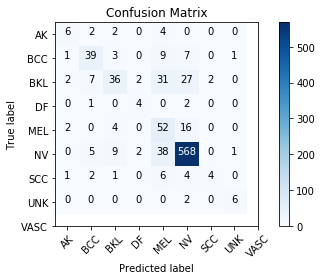

In [60]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['AK', 'BCC', 'BKL', 'DF', 'MEL','NV', 'SCC', 'UNK', 'VASC']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [61]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [62]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

             precision    recall  f1-score   support

         AK       0.50      0.43      0.46        14
        BCC       0.70      0.65      0.67        60
        BKL       0.65      0.34      0.44       107
         DF       0.50      0.57      0.53         7
        MEL       0.37      0.70      0.49        74
         NV       0.91      0.91      0.91       623
        SCC       0.67      0.22      0.33        18
        UNK       0.75      0.75      0.75         8

avg / total       0.80      0.78      0.78       911



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 8, does not match size of target_names, 9
  .format(len(labels), len(target_names))
